# Filtering a Time Series with CNN

In [2]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [4]:
print(tf.__version__)

2.13.1


In [5]:
tf.random.set_seed(42)
np.random.seed(42)

In this chapter, we’ll also combine the CNN architecture with the LSTM architecture. It
can be interesting to see if filtering our time series with a convolution layer and then processing the filtered sequence with an LSTM will improve the accuracy of our predictions.
Thus, we’ll implement both a CNN only, and the combination of a CNN with an LSTM.

In [7]:
train_df = pd.read_csv('data/train.csv', index_col=0)
val_df = pd.read_csv('data/val.csv', index_col=0)
test_df = pd.read_csv('data/test.csv', index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)

(12285, 5) (3510, 5) (1756, 5)


In [8]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [9]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [10]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

## CNN 

### Single-step model 

In [13]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

conv_window = DataWindow(input_width=KERNEL_WIDTH, label_width=1, shift=1, label_columns=['traffic_volume'])
wide_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1, label_columns=['traffic_volume'])

In [14]:
# Values obtained from chapter 15

mae_val = [0.083, 0.068, 0.033, 0.03]
mae_test = [0.081, 0.068, 0.029, 0.026]

In [15]:
cnn_model = Sequential([
    Conv1D(filters=32,
          kernel_size=(KERNEL_WIDTH,),
          activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(cnn_model, conv_window)

val_performance = {}
performance = {}

val_performance['CNN'] = cnn_model.evaluate(conv_window.val)
performance['CNN'] = cnn_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 2s 4ms/step - loss: 0.0174 - mean_absolute_error: 0.0896 - val_loss: 0.0056 - val_mean_absolute_error: 0.0539
Epoch 2/50
384/384 [==============================] - 1s 3ms/step - loss: 0.0053 - mean_absolute_error: 0.0527 - val_loss: 0.0041 - val_mean_absolute_error: 0.0475
Epoch 3/50
384/384 [==============================] - 1s 3ms/step - loss: 0.0041 - mean_absolute_error: 0.0466 - val_loss: 0.0034 - val_mean_absolute_error: 0.0423
Epoch 4/50
384/384 [==============================] - 1s 3ms/step - loss: 0.0037 - mean_absolute_error: 0.0441 - val_loss: 0.0035 - val_mean_absolute_error: 0.0431
Epoch 5/50
384/384 [==============================] - 1s 3ms/step - loss: 0.0034 - mean_absolute_error: 0.0417 - val_loss: 0.0030 - val_mean_absolute_error: 0.0401
Epoch 6/50
384/384 [==============================] - 1s 3ms/step - loss: 0.0032 - mean_absolute_error: 0.0405 - val_loss: 0.0025 - val_mean_absolute_error: 0.0360
Epoch 7/50
384/3

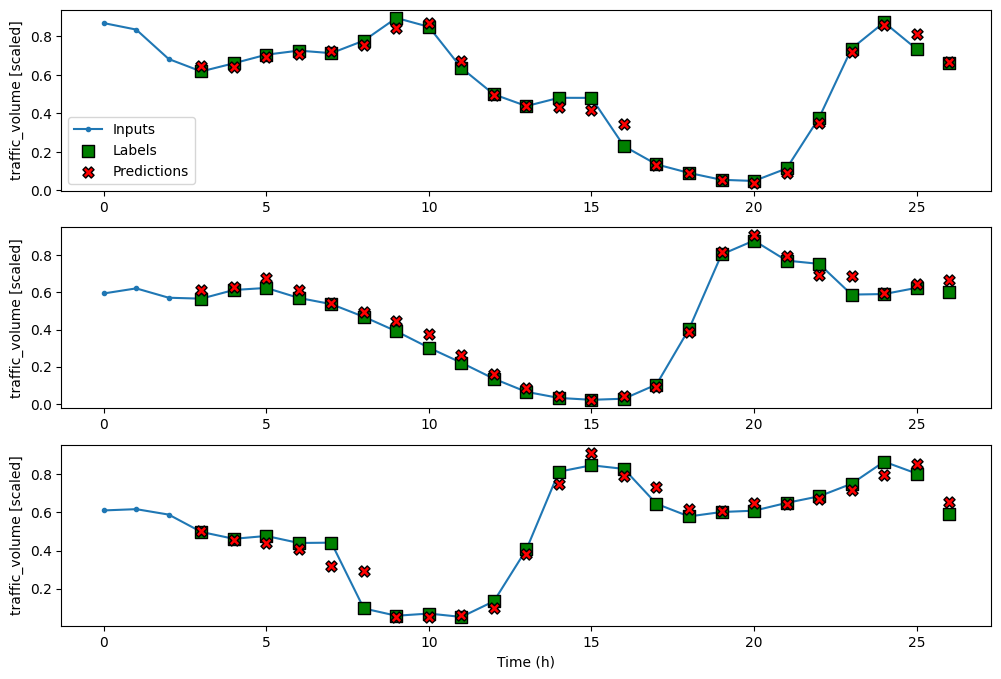

In [16]:
wide_conv_window.plot(cnn_model)

*Predicting traffic volume with a CNN as a single-step model. The model takes three values as an
input, which is why we only see a prediction at the fourth timestep. Again, many predictions (shown as
crosses) overlap labels (shown as squares), meaning that the model is fairly accurate.*

#### CNN + LSTM 

In [18]:
cnn_lstm_model = Sequential([
    Conv1D(filters=32,
          kernel_size=(KERNEL_WIDTH,),
          activation='relu'),
    LSTM(32, return_sequences=True),
    LSTM(32, return_sequences=True),
    Dense(1)
])

history = compile_and_fit(cnn_lstm_model, conv_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(conv_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 13s 11ms/step - loss: 0.0351 - mean_absolute_error: 0.1261 - val_loss: 0.0084 - val_mean_absolute_error: 0.0663
Epoch 2/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0072 - mean_absolute_error: 0.0614 - val_loss: 0.0058 - val_mean_absolute_error: 0.0556
Epoch 3/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0057 - mean_absolute_error: 0.0545 - val_loss: 0.0046 - val_mean_absolute_error: 0.0492
Epoch 4/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0048 - mean_absolute_error: 0.0504 - val_loss: 0.0035 - val_mean_absolute_error: 0.0439
Epoch 5/50
384/384 [==============================] - 2s 6ms/step - loss: 0.0040 - mean_absolute_error: 0.0460 - val_loss: 0.0034 - val_mean_absolute_error: 0.0438
Epoch 6/50
384/384 [==============================] - 3s 6ms/step - loss: 0.0036 - mean_absolute_error: 0.0434 - val_loss: 0.0041 - val_mean_absolute_error: 0.0502
Epoch 7/50
384

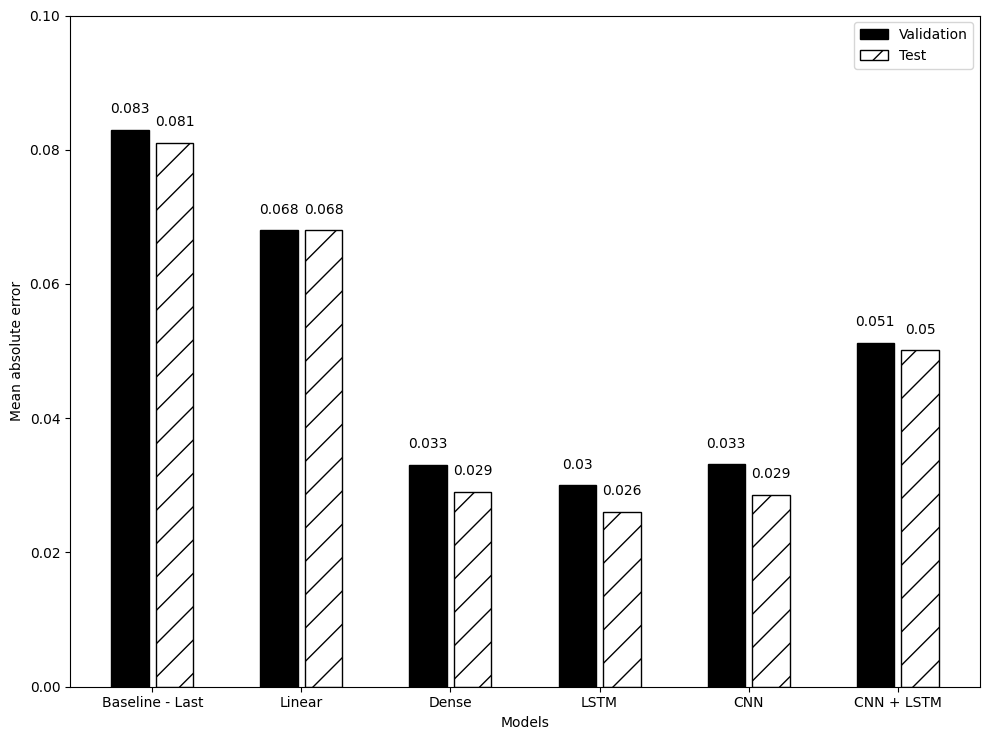

In [19]:
mae_val.extend([v[1] for v in val_performance.values()])
mae_test.extend([v[1] for v in performance.values()])

x = np.arange(6)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

*The MAE of all the single-step models built so far. You can see that the CNN did not improve
upon the LSTM performance. Combining the CNN with an LSTM did not help either, and the combination even
performed slightly worse than the CNN.*

### Multi-step model 

In [21]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=24, label_columns=['traffic_volume'])

In [22]:
# Values obtained from chapter 15

ms_mae_val = [0.352, 0.347, 0.088, 0.078, 0.070]
ms_mae_test = [0.347, 0.341, 0.076, 0.064, 0.058]

In [23]:
ms_cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_cnn_model, multi_window)

ms_val_performance = {}
ms_performance = {}

ms_val_performance['CNN'] = ms_cnn_model.evaluate(multi_window.val)
ms_performance['CNN'] = ms_cnn_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 [==============================] - 3s 5ms/step - loss: 0.0357 - mean_absolute_error: 0.1243 - val_loss: 0.0167 - val_mean_absolute_error: 0.0852
Epoch 2/50
383/383 [==============================] - 2s 5ms/step - loss: 0.0143 - mean_absolute_error: 0.0792 - val_loss: 0.0160 - val_mean_absolute_error: 0.0833
Epoch 3/50
383/383 [==============================] - 2s 4ms/step - loss: 0.0139 - mean_absolute_error: 0.0783 - val_loss: 0.0161 - val_mean_absolute_error: 0.0874
Epoch 4/50
383/383 [==============================] - 2s 5ms/step - loss: 0.0136 - mean_absolute_error: 0.0778 - val_loss: 0.0153 - val_mean_absolute_error: 0.0820
Epoch 5/50
383/383 [==============================] - 2s 4ms/step - loss: 0.0135 - mean_absolute_error: 0.0775 - val_loss: 0.0153 - val_mean_absolute_error: 0.0824
Epoch 6/50
383/383 [==============================] - 2s 4ms/step - loss: 0.0133 - mean_absolute_error: 0.0769 - val_loss: 0.0150 - val_mean_absolute_error: 0.0822
Epoch 7/50
383/3

#### CNN + LSTM 

In [25]:
ms_cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_cnn_lstm_model, multi_window)

ms_val_performance['CNN + LSTM'] = ms_cnn_lstm_model.evaluate(multi_window.val)
ms_performance['CNN + LSTM'] = ms_cnn_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 [==============================] - 11s 16ms/step - loss: 0.0441 - mean_absolute_error: 0.1508 - val_loss: 0.0174 - val_mean_absolute_error: 0.0903
Epoch 2/50
383/383 [==============================] - 6s 14ms/step - loss: 0.0146 - mean_absolute_error: 0.0813 - val_loss: 0.0161 - val_mean_absolute_error: 0.0842
Epoch 3/50
383/383 [==============================] - 6s 15ms/step - loss: 0.0140 - mean_absolute_error: 0.0789 - val_loss: 0.0157 - val_mean_absolute_error: 0.0819
Epoch 4/50
383/383 [==============================] - 6s 16ms/step - loss: 0.0137 - mean_absolute_error: 0.0776 - val_loss: 0.0155 - val_mean_absolute_error: 0.0799
Epoch 5/50
383/383 [==============================] - 6s 16ms/step - loss: 0.0135 - mean_absolute_error: 0.0768 - val_loss: 0.0160 - val_mean_absolute_error: 0.0801
Epoch 6/50
383/383 [==============================] - 5s 14ms/step - loss: 0.0133 - mean_absolute_error: 0.0763 - val_loss: 0.0152 - val_mean_absolute_error: 0.0803
Epoch 7/5

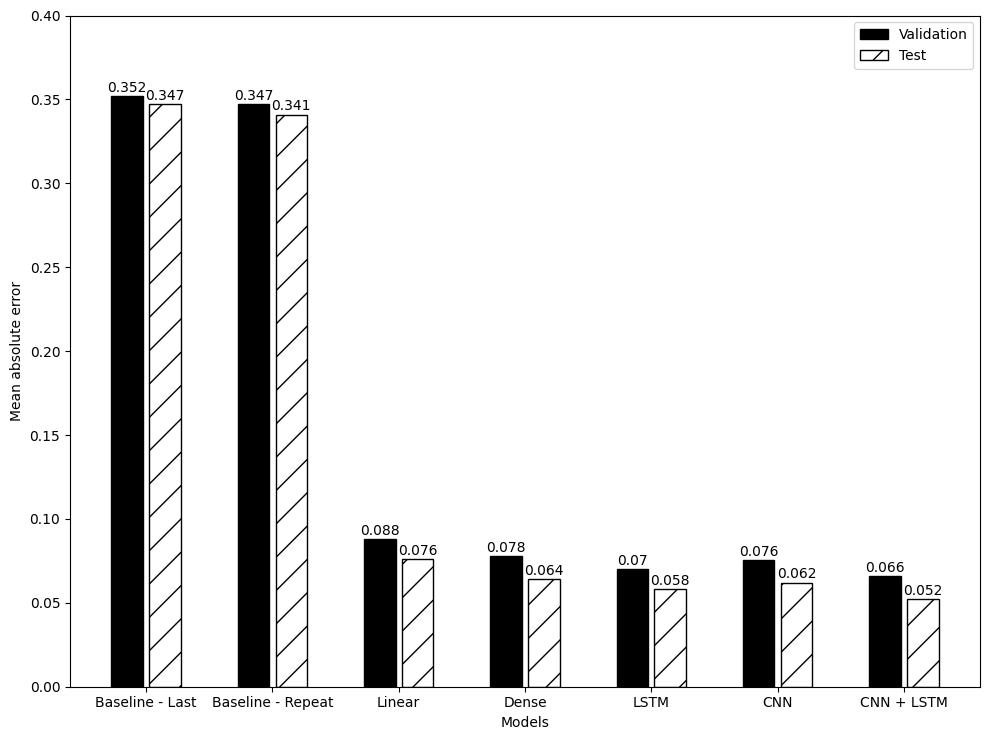

In [26]:
ms_mae_val.extend([v[1] for v in ms_val_performance.values()])
ms_mae_test.extend([v[1] for v in ms_performance.values()])

x = np.arange(7)

labels = ['Baseline - Last', 'Baseline - Repeat', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

*The MAE of all multi-step models built so far. The CNN model is worse than the LSTM model,
since it has a higher MAE. However, combining the CNN with an LSTM resulted in the lowest MAE of all.*

### Multi-output model 

In [28]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

wide_mo_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=24, shift=1, label_columns=['temp', 'traffic_volume'])

In [29]:
# Values from chapter 15

mo_mae_val = [0.048, 0.039, 0.023, 0.020]
mo_mae_test = [0.047, 0.036, 0.020, 0.017]

In [30]:
mo_cnn_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=2)
])

history = compile_and_fit(mo_cnn_model, wide_mo_conv_window)

mo_val_performance = {}
mo_performance = {}

mo_val_performance['CNN'] = mo_cnn_model.evaluate(wide_mo_conv_window.val)
mo_performance['CNN'] = mo_cnn_model.evaluate(wide_mo_conv_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 3s 5ms/step - loss: 0.0110 - mean_absolute_error: 0.0643 - val_loss: 0.0028 - val_mean_absolute_error: 0.0354
Epoch 2/50
384/384 [==============================] - 2s 4ms/step - loss: 0.0024 - mean_absolute_error: 0.0321 - val_loss: 0.0018 - val_mean_absolute_error: 0.0292
Epoch 3/50
384/384 [==============================] - 2s 4ms/step - loss: 0.0019 - mean_absolute_error: 0.0279 - val_loss: 0.0015 - val_mean_absolute_error: 0.0265
Epoch 4/50
384/384 [==============================] - 2s 4ms/step - loss: 0.0017 - mean_absolute_error: 0.0263 - val_loss: 0.0014 - val_mean_absolute_error: 0.0259
Epoch 5/50
384/384 [==============================] - 2s 4ms/step - loss: 0.0016 - mean_absolute_error: 0.0254 - val_loss: 0.0013 - val_mean_absolute_error: 0.0245
Epoch 6/50
384/384 [==============================] - 2s 4ms/step - loss: 0.0016 - mean_absolute_error: 0.0247 - val_loss: 0.0013 - val_mean_absolute_error: 0.0239
Epoch 7/50
384/3

In [31]:
mo_cnn_lstm_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation='relu'),
    LSTM(32, return_sequences=True),
    Dense(units=2)
])

history = compile_and_fit(mo_cnn_lstm_model, wide_mo_conv_window)

mo_val_performance['CNN + LSTM'] = mo_cnn_model.evaluate(wide_mo_conv_window.val)
mo_performance['CNN + LSTM'] = mo_cnn_model.evaluate(wide_mo_conv_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 11s 17ms/step - loss: 0.0233 - mean_absolute_error: 0.0927 - val_loss: 0.0042 - val_mean_absolute_error: 0.0438
Epoch 2/50
384/384 [==============================] - 6s 14ms/step - loss: 0.0031 - mean_absolute_error: 0.0366 - val_loss: 0.0022 - val_mean_absolute_error: 0.0321
Epoch 3/50
384/384 [==============================] - 6s 14ms/step - loss: 0.0023 - mean_absolute_error: 0.0312 - val_loss: 0.0019 - val_mean_absolute_error: 0.0305
Epoch 4/50
384/384 [==============================] - 6s 15ms/step - loss: 0.0020 - mean_absolute_error: 0.0292 - val_loss: 0.0018 - val_mean_absolute_error: 0.0295
Epoch 5/50
384/384 [==============================] - 6s 15ms/step - loss: 0.0019 - mean_absolute_error: 0.0278 - val_loss: 0.0016 - val_mean_absolute_error: 0.0288
Epoch 6/50
384/384 [==============================] - 6s 15ms/step - loss: 0.0018 - mean_absolute_error: 0.0268 - val_loss: 0.0015 - val_mean_absolute_error: 0.0266
Epoch 7/5

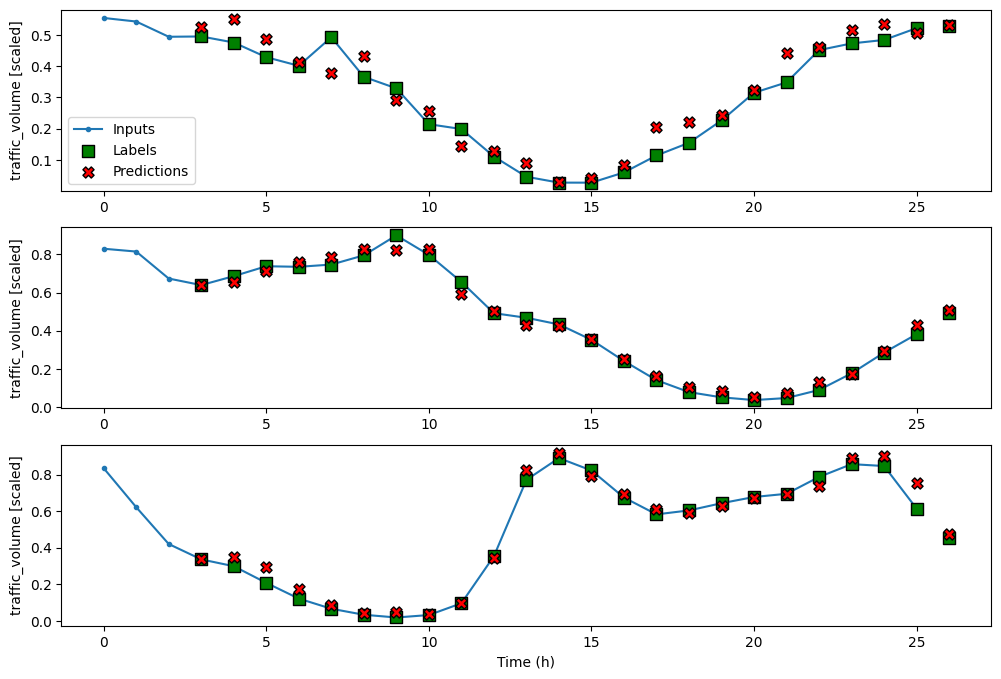

In [32]:
wide_mo_conv_window.plot(mo_cnn_lstm_model)

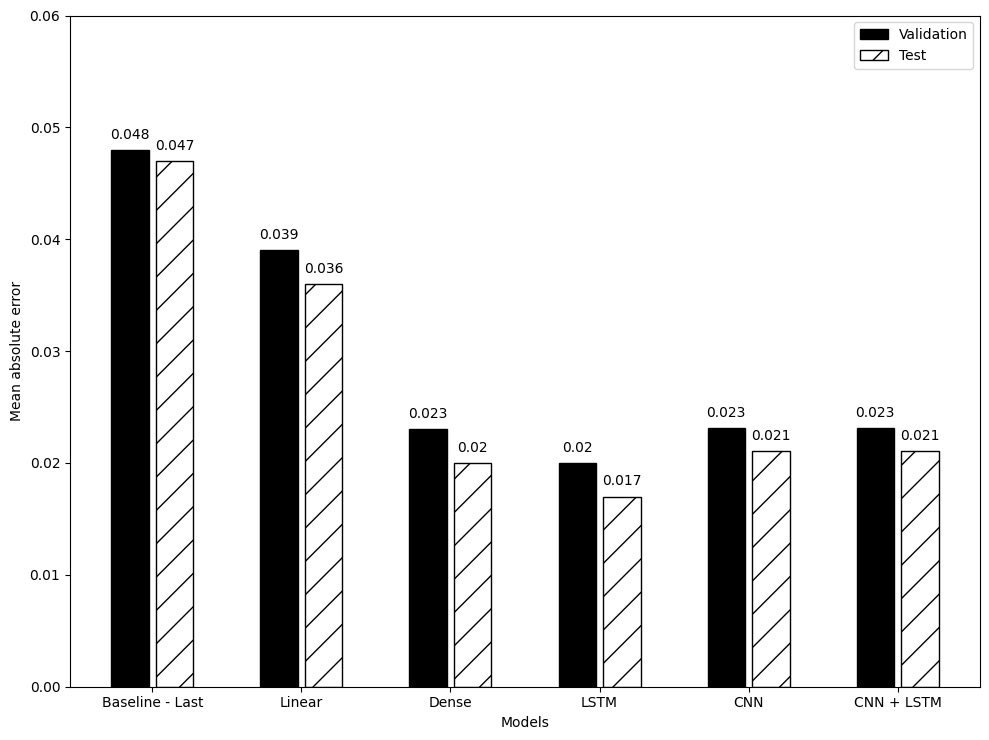

In [33]:
mo_mae_val.extend([v[1] for v in mo_val_performance.values()])
mo_mae_test.extend([v[1] for v in mo_performance.values()])

x = np.arange(6)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.001, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.001, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

*The MAE of all multi-output models built so far. As you can see, the CNN and the combination
of CNN and LSTM did not result in improvements over the LSTM model.*

#### Summary
The convolutional neural network (CNN) is a deep learning architecture that
makes use of the convolution operation.

The convolution operation is performed between a kernel and the feature
space. It is simply the dot product between the kernel and the feature vector.

Running a convolution operation results in an output sequence that is shorter
than the input sequence. Running many convolutions can therefore decrease
the output length quickly. Padding can be used to prevent that.

In time series forecasting, the convolution is performed in one dimension only:
the temporal dimension.

The CNN is just another model in your toolbox and may not always be the bestperforming model. Make sure you window your data correctly with DataWindow,
and keep your testing methodology valid by keeping each set of data constant,
building baseline models, and evaluating all models with the same error metric.